### Imports

In [1]:
import sys
mypath = "/home/basia/Documents/spectroscopy/magnetstein"
sys.path.insert(0, mypath)

In [2]:
import numpy as np
import pandas as pd
import os
from masserstein import NMRSpectrum, estimate_proportions
import matplotlib.pyplot as plt
import pulp
import pickle

### Data

In [3]:
experiment_name = 'Saccharose hydrolysis'

In [4]:
mixture_paths = {'Saccharose hydrolysis': '../data/saccharose_hydrolysis/preprocessed_mixture.csv',
                'PMG 284 monitoring': '../data/PMG_284/preprocessed_mixture.csv',
                'PMG 287 monitoring': '../data/PMG_287/preprocessed_mixture_cut_to_regions.csv'
                }

reagents_paths = {'Saccharose hydrolysis': ['../data/saccharose_hydrolysis/preprocessed_saccharose.csv', 
                                            '../data/saccharose_hydrolysis/preprocessed_alpha_glucose.csv',
                                            '../data/saccharose_hydrolysis/preprocessed_beta_glucose.csv',
                                            '../data/saccharose_hydrolysis/preprocessed_fructose.csv'],
                'PMG 284 monitoring': ['../data/PMG_284/preprocessed_pentene.csv',
                                      '../data/PMG_284/preprocessed_triethylsilane.csv',
                                      '../data/PMG_284/preprocessed_product.csv'],
                'PMG 287 monitoring': ['../data/PMG_287/preprocessed_hexene.csv',
                                      '../data/PMG_287/preprocessed_triethylsilane.csv',
                                      '../data/PMG_287/preprocessed_product.csv']}

mixture_separators = {'Saccharose hydrolysis': '\t',
                'PMG 284 monitoring': '\t',
                'PMG 287 monitoring': '\t'
                }

reagents_separators = {'Saccharose hydrolysis': '\t',
                'PMG 284 monitoring': '\t',
                'PMG 287 monitoring': '\t'
                }

results_paths = {'Saccharose hydrolysis': '../results/saccharose_hydrolysis/',
                'PMG 284 monitoring': '../results/PMG_284/',
                'PMG 287 monitoring': '../results/PMG_287/cut_spectrum_of_mixture/'}

#### Mixture in time

In [5]:
mixture_time_data = pd.read_csv(mixture_paths[experiment_name], sep = mixture_separators[experiment_name])


In [6]:
mixture_time_data = pd.read_csv(mixture_paths[experiment_name], sep = mixture_separators[experiment_name])
if experiment_name == 'Saccharose hydrolysis':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_10th = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)
elif experiment_name == 'PMG 284 monitoring':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_10th = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)
elif experiment_name == 'PMG 287 monitoring':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_10th = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)

In [7]:
names = ['ppm'] + ['t' + str(nb) for nb in range(1, mixture_time_data.shape[1])]

In [8]:
mixture_time_data.columns = names

In [9]:
def load_spectrum(mixture_time_data, moment_of_time):
    ppm = mixture_time_data['ppm']
    intensity = mixture_time_data['t'+str(moment_of_time)]
    sp = NMRSpectrum(confs = list(zip(ppm, intensity)))
    sp.trim_negative_intensities()
    sp.normalize()
    return sp

#### Reagents

In [10]:
reagents_spectra = []
for reagent in reagents_paths[experiment_name]:
    reag = pd.read_csv(reagent, sep=reagents_separators[experiment_name], header=None).iloc[:,:2]
    reagents_spectra.append(reag)

In [11]:
reagents_spectra2 = []
for reag in reagents_spectra:
    ppm = reag.iloc[:,0]
    ints = reag.iloc[:,1]
    sp = NMRSpectrum(confs = list(zip(ppm, ints)))
    reagents_spectra2.append(sp)
reagents_spectra = reagents_spectra2
del(reagents_spectra2)

In [12]:
for sp in reagents_spectra:
    sp.trim_negative_intensities()
    sp.normalize()

In [13]:
reagents_spectra

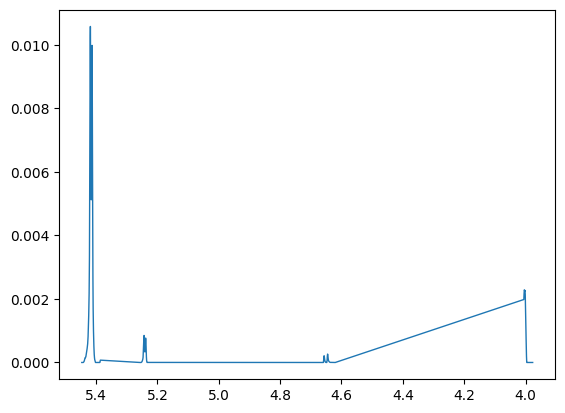

In [14]:
plt.gca().invert_xaxis()
NMRSpectrum.plot(load_spectrum(mixture_time_data, 30), profile=True)
#NMRSpectrum.plot_all(reagents_spectra + [load_spectrum(mixture_time_data, 100)], profile=True)

### Estimation

In [15]:
kappa = 0.25
kappa_th = 0.25
#0.25, 0.25

In [16]:
proportions_in_times = []
noise_proportions_in_times = []
noise = []
noise_in_components = []

for i in range(1, mixture_time_data.shape[1]):
    print('This is timepoint '+str(i)+'.\n')
    mix = load_spectrum(mixture_time_data, i)
    mix.trim_negative_intensities()
    mix.normalize()
    estimation = estimate_proportions(mix, reagents_spectra, what_to_compare='area', 
                                      solver=pulp.GUROBI(msg=False),
                                     MTD=kappa, MTD_th=kappa_th)
    proportions_in_times.append(estimation['proportions'])
    noise_proportions_in_times.append(estimation['proportion_of_noise_in_components'])
    noise.append(estimation['noise'])
    noise_in_components.append(estimation['noise_in_components'])
#     if i>1:
#         assert estimation['common_horizontal_axis'] == common_horizontal_axis
    common_horizontal_axis = estimation['common_horizontal_axis']
    
    print('Proportions:\n')
    print(estimation['proportions'])
    print('\n')
    print('Proportion_of_noise_in_components:\n')
    print(estimation['proportion_of_noise_in_components'])
    print('\n')

This is timepoint 1.

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
Proportions:

[0.9959509450410005, 0.0021461670610000007, 0.00019065337100000008, 0.001712234527000001]


Proportion_of_noise_in_components:

0.0


This is timepoint 2.



/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Proportions:

[0.989896169936, 0.005200429766, 0.000287673407, 0.004615726891]


Proportion_of_noise_in_components:

0.0


This is timepoint 3.

Proportions:

[0.9833093853960004, 0.007920556669000003, 0.00044563434300000024, 0.008324423593000004]


Proportion_of_noise_in_components:

0.0


This is timepoint 4.

Proportions:

[0.9772952597249995, 0.010142146983999996, 0.0006593078079999996, 0.011903285482999995]


Proportion_of_noise_in_components:

0.0


This is timepoint 5.

Proportions:

[0.9698286378019997, 0.012246762993999996, 0.0009093396149999997, 0.017015259587999994]


Proportion_of_noise_in_components:

0.0


This is timepoint 6.

Proportions:

[0.9643064402629999, 0.013862935355999998, 0.0012380702689999998, 0.020592554112999997]


Proportion_of_noise_in_components:

0.0


This is timepoint 7.

Proportions:

[0.9568855600760002, 0.015837290758000003, 0.0016669219480000004, 0.025610227218000006]


Proportion_of_noise_in_components:

0.0


This is timepoint 8.

Proportions:



Proportions:

[0.640782995413, 0.082106319433, 0.023829942828, 0.253280742326]


Proportion_of_noise_in_components:

0.0


This is timepoint 54.

Proportions:

[0.6473080569559996, 0.08211277565699994, 0.024823313451999982, 0.24575585393599983]


Proportion_of_noise_in_components:

0.0


This is timepoint 55.

Proportions:

[0.604812545019, 0.082190441808, 0.025345382777, 0.287651630396]


Proportion_of_noise_in_components:

0.0


This is timepoint 56.

Proportions:

[0.6229757536510002, 0.08085972937400004, 0.02371561658700001, 0.2724489003880001]


Proportion_of_noise_in_components:

0.0


This is timepoint 57.

Proportions:

[0.6065970565019999, 0.08698462699399999, 0.026041739577999996, 0.28037657692699997]


Proportion_of_noise_in_components:

0.0


This is timepoint 58.

Proportions:

[0.6017052838410004, 0.08465998068000005, 0.024995883252000018, 0.28863885222600016]


Proportion_of_noise_in_components:

0.0


This is timepoint 59.

Proportions:

[0.5848645775130001, 0.091157080

In [17]:
len(proportions_in_times)

103

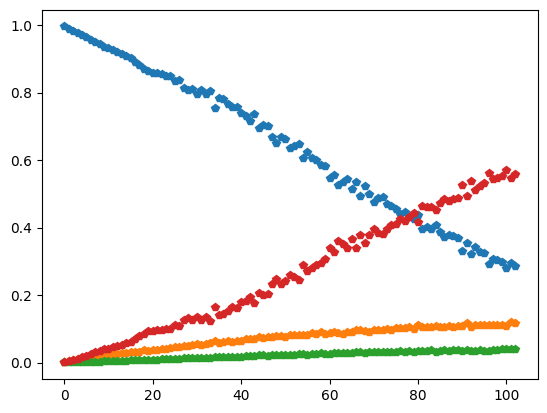

In [18]:
for i in range(len(reagents_spectra)):
    plt.plot(range(len(proportions_in_times)), [prop[i] for prop in proportions_in_times], 'p')

In [19]:
with open(results_paths[experiment_name]+'proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(proportions_in_times, f)

In [20]:
with open(results_paths[experiment_name]+'noise_proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(noise_proportions_in_times, f)

In [21]:
with open(results_paths[experiment_name]+'common_horizontal_axis_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(common_horizontal_axis, f)

In [22]:
with open(results_paths[experiment_name]+'noise_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(noise, f)

In [23]:
with open(results_paths[experiment_name]+'noise_in_components_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(noise_in_components, f)